In [1]:
import os
import numpy as np
from osgeo import gdal
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as py
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import sys
import pandas as pd

import parflow as pf
from parflow.tools.io import read_pfb,write_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

In [2]:
# Directory where PF flow PFBs are saved in
# directory_out = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/averages'
# organized_dir = '/glade/p/univ/ucsm0002/CONUS2/Validation/Streamflow/Organized_Daily_Flow'
directory_out = '/glade/p/univ/ucsm0002/ICOM_danielle/averages'
organized_dir = '/glade/work/tijerina/subsurface_paper/my_validation_scripts/WTD/Organized_WTD'

usgs_data = 'selected_gages_flow_WY2003.csv' #csv of USGS flow from hydrodata

# Where you want to save plots, etc. to
plot_dir = '/glade/work/tijerina/subsurface_paper/my_validation_scripts/WTD/Figures'

# need to change water year and number of days
water_year = 2003
no_days = 364 

In [22]:
### READING ALL STATIC VARIABLES AND DOMAIN INFO NEEDED ###
## DATA ACCESSOR VARIABLES 
run = Run.from_definition('/glade/p/univ/ucsm0002/ICOM_danielle/icom-modeling/runs/icom_clm_WY2003/icom.pfidb') 

data = run.data_accessor

## formatting the mask so that values outside the domain are NA and inside the domain are 1
mask = data.mask
active_mask=mask.copy()
active_mask[active_mask > 0] = 1


  - nt
  - sw_ini
  - qflx_tran_vegm
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx


In [26]:
### READ WTD PFBs ###
# Read in CONUS2 daily WTD PFBs and save as df
wtd_days = np.zeros((no_days,480,416)) 

for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    wtd_days[i,...] = np.squeeze(read_pfb(f'{directory_out}/WTD.2003.daily.{step}.pfb'))*active_mask[9,...]
    print(f'reading WTD for day {step}')

reading WTD for day 001
reading WTD for day 002
reading WTD for day 003
reading WTD for day 004
reading WTD for day 005
reading WTD for day 006
reading WTD for day 007
reading WTD for day 008
reading WTD for day 009
reading WTD for day 010
reading WTD for day 011
reading WTD for day 012
reading WTD for day 013
reading WTD for day 014
reading WTD for day 015
reading WTD for day 016
reading WTD for day 017
reading WTD for day 018
reading WTD for day 019
reading WTD for day 020
reading WTD for day 021
reading WTD for day 022
reading WTD for day 023
reading WTD for day 024
reading WTD for day 025
reading WTD for day 026
reading WTD for day 027
reading WTD for day 028
reading WTD for day 029
reading WTD for day 030
reading WTD for day 031
reading WTD for day 032
reading WTD for day 033
reading WTD for day 034
reading WTD for day 035
reading WTD for day 036
reading WTD for day 037
reading WTD for day 038
reading WTD for day 039
reading WTD for day 040
reading WTD for day 041
reading WTD for 

In [29]:
wtd_days.shape

(364, 480, 416)

In [30]:
# Sum all daily wtd at each cell, divide by 365 for annual average (daily) ?
wtd_year = np.sum(wtd_days, axis = 0)/365
wtd_year.shape

(480, 416)

In [31]:
wtd_year[300,300]

105.41613433029866

In [32]:
### check gage locations for daily flow
well_data = pd.read_csv(f'{organized_dir}/icom_wells.csv')
well_data.head()

,x,y,obs
0,6,297,40.64
1,7,300,37.22
2,6,302,23.54
3,8,308,43.31
4,6,311,17.33


In [33]:
# set up dataframe with obs and PF WTD
wtd_df = pd.DataFrame(columns = ['i_index','j_index','obs','PF'])
wtd_df['obs'] = well_data['obs']
wtd_df['i_index'] = well_data['x']
wtd_df['j_index'] = -well_data['y']

In [34]:
wtd_df['PF'] = wtd_year[-well_data['y'],well_data['x']] # find daily average for the water year
wtd_df

,i_index,j_index,obs,PF
0,6,-297,40.64,69.371697
1,7,-300,37.22,80.692388
2,6,-302,23.54,43.868339
3,8,-308,43.31,39.857112
4,6,-311,17.33,40.864663
...,...,...,...,...
8673,404,-293,0.61,0.188931
8674,404,-303,2.90,0.209673
8675,405,-326,0.61,0.241499
8676,405,-276,5.49,0.204771


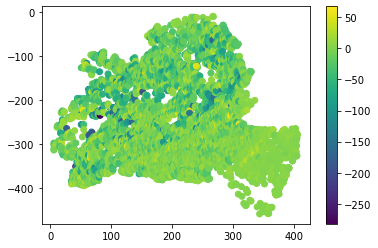

In [48]:
fig, ax = plt.subplots()
diff = wtd_df.obs-wtd_df.PF
im = ax.scatter(wtd_df.i_index, wtd_df.j_index, c=diff)
plt.colorbar(im)
#ax.plot(range(364), pf_flow_matched.loc[1446500])
#ax.legend(['Obs', 'PF'])

(array([4257., 2623., 1031.,  385.,  181.,  113.,   50.,   21.,   11.,
           6.]),
 array([ 0.   ,  8.382, 16.764, 25.146, 33.528, 41.91 , 50.292, 58.674,
        67.056, 75.438, 83.82 ]),
 <BarContainer object of 10 artists>)

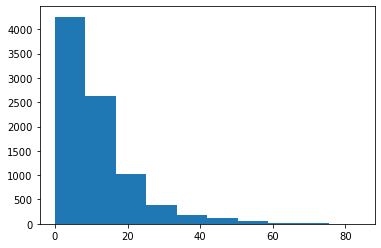

In [38]:
fig, ax = plt.subplots()
ax.hist(wtd_df.obs)

(array([6.272e+03, 1.613e+03, 5.540e+02, 1.500e+02, 5.800e+01, 1.100e+01,
        1.100e+01, 4.000e+00, 2.000e+00, 3.000e+00]),
 array([  0.        ,  29.44943115,  58.89886231,  88.34829346,
        117.79772461, 147.24715577, 176.69658692, 206.14601807,
        235.59544923, 265.04488038, 294.49431153]),
 <BarContainer object of 10 artists>)

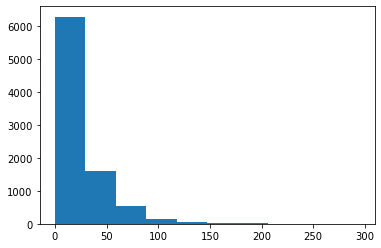

In [39]:
fig, ax = plt.subplots()
ax.hist(wtd_df.PF)

In [40]:
# # SAVE OUT PANDAS DF FOR CONUS2 FLOW
# ### save csv file of all matching gage locations and CONUS2 daily flow, note the USGS STNID's drop the leading zeros when saving
wtd_df.to_csv(f'{organized_dir}/ICOM_Obs_WTD_{water_year}.csv', sep = ",")

In [ ]:
# indi_file = sys.argv[1]
RUN_NAME = sys.argv[1]
wtd_file = RUN_NAME + '_wtd.npy'
# wtd_file = sys.argv[2]
obs_file = 'icom_wells.csv'
# RUN_NAME = sys.argv[4]
########################

#Read indicator file
# indi_arr = pfio.pfread(indi_file)[:, ::-1, :]

vertical_dis = {4 : 7, 5 : 17, 6 : 42, 7 : 92, 8 : 192, 9: 1192}

indi_to_K = {19:0.005, 20: 0.01, 21:0.02, 22:0.03, 23:0.04, 24:0.05, 25:0.06,
			26:0.08, 27:0.1, 28:0.2}

#Read Shangguan depth dataset
# ds_reg = gdal.Open('shp/Regions.tif')
ds_reg = gdal.Open('icom_mask_final.tif')
geom_reg = ds_reg.GetGeoTransform()
arr_reg = ds_reg.ReadAsArray()

yy0,xx0 = np.where(arr_reg == 1)
# yy0,xx0 = np.where(arr_reg == sel_basin)
new_arr = arr_reg[min(yy0):max(yy0)+1,min(xx0):max(xx0)+1]
len_y, len_x = new_arr.shape
new_len_y = ((len_y//32)+1)*32
n1 = (new_len_y-len_y)//2
n2 = new_len_y-len_y-n1
new_len_x = ((len_x//32)+1)*32
n3 = (new_len_x-len_x)//2
n4 = new_len_x-len_x-n3

# Depth = gdal.Open('extract_results/tmp_shangguan_reprojected.tif').ReadAsArray()           # Used to specify K-set
# sel_depth = Depth[min(yy0)-n1:max(yy0)+n2+1,min(xx0)-n3:max(xx0)+n4+1]

# Read wtd file
wtd_arr = np.load(wtd_file)
sel_mean = np.mean(wtd_arr, axis = 0)

# Read obs file
obs_df = pd.read_csv(obs_file)
obs_xs = np.array(obs_df.x)
obs_ys = np.array(obs_df.y)
obs_wtd = np.array(obs_df.obs)

### Compare with Yin Fan compiled wells
sim_wtds = []
# sim_depths = []
# sim_kis = []

for ii, x in enumerate(obs_xs):
	y = obs_ys[ii]
	obsi = obs_wtd[ii]
	simi = sel_mean[y, x]
	# depthi = sel_depth[y, x]
	# for disi in sorted(vertical_dis.keys()):
	# 	if depthi <= vertical_dis[disi]:
	# 		if indi_arr.shape[0] < 10:
	# 			ki = indi_arr[4, y, x]
	# 		else:
	# 			ki = indi_arr[disi, y, x]
	# 		break
	# """
	# if idi in indi_to_K.keys():
	# 	ki = indi_to_K[idi]
	# else:
	# 	ki = 1
	# """
	i = 0
	while (np.isnan(simi)) and (i < 10):
		ensemble_simi = sel_mean[y - 2: y + 2, x - 2: x + 2].ravel()
		simi = ensemble_simi[i]
		i += 1
	if np.isnan(simi):
		print('error at x: '+str(x))
	sim_wtds.append(simi)
	# sim_kis.append(ki)
	# sim_depths.append(depthi)

obs_wtd = np.array(obs_wtd)
sim_wtds = np.array(sim_wtds)
# sim_kis = np.array(sim_kis)
# sim_depths = np.array(sim_depths)

#%%
### SCATTER PLOT
overall_corr = np.round(np.corrcoef(obs_wtd, sim_wtds)[0,1],2)
wtd_threshold = [0, 10, 20, 30, 40, 50, 100]

fig, axs = plt.subplots(1, 7, figsize = (20, 4))
ax0 = axs[0]
sca0 = ax0.scatter(obs_wtd, sim_wtds, alpha = 0.4, s = 10, 
			# c = sim_kis,
			norm =mpl.colors.LogNorm(1e-3, 1e-1))
# sca0 = ax0.scatter(obs_wtd, sim_wtds, alpha = 0.4, s = 10)
ax0.set_ylim(0, 150)
ax0.set_xlim(0, 150)
ax0.text(70, 105, overall_corr, size = 30)
ax0.set_aspect(1)
ax0.set_title('overall')
ax0.set_ylabel(RUN_NAME, size = 20)
#divider = make_axes_locatable(ax0)
#cax = divider.append_axes('left', size='5%', pad=0.8)
#fig.colorbar(sca0, cax=cax, orientation='vertical')

for i in range(1, 7):
	ax = axs[i]
	sel_points = np.logical_or(np.logical_and(obs_wtd > wtd_threshold[i - 1],
											  obs_wtd <= wtd_threshold[i]),
							   np.logical_and(sim_wtds > wtd_threshold[i - 1],
											  sim_wtds <= wtd_threshold[i]))
	sub_obs = obs_wtd[sel_points]
	sub_wtd = sim_wtds[sel_points]
	sub_corr = np.round(np.corrcoef(sub_obs, sub_wtd)[0,1],2)
	# sub_kis = sim_kis[sel_points]
	ax.set_title('WTD < '+str(wtd_threshold[i]), size = 15)
	ax.scatter(sub_obs, sub_wtd, alpha = 0.4, s = 10, 
			#c = sub_kis,
			norm =mpl.colors.LogNorm(1e-3, 1e-1))
	# ax.scatter(sub_obs, sub_wtd, alpha = 0.4, s = 10)
	y_max = 40 + wtd_threshold[i]
	x_max = 40 + wtd_threshold[i]
	ax.set_ylim(0, y_max)
	ax.set_xlim(0, x_max)
	ax.text(x_max * 0.5, y_max * 0.7, sub_corr, size = 30)
	ax.set_aspect(1)

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.1])
fig.colorbar(sca0, cax=cbar_ax, orientation = 'horizontal')
plt.savefig(RUN_NAME+'_scatter.png')

#%%
### Map plot
fig, axs = plt.subplots(1, 2, figsize = (16, 8))
ax0 = axs[0]
im0 = ax0.imshow(sel_mean, cmap = 'RdYlBu',
			norm =mpl.colors.LogNorm(1, 100))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('left', size='5%', pad=0.8)
fig.colorbar(im0, cax=cax, orientation='vertical')
ax0.set_title('Simulated WTD')

ax1 = axs[1]
sca1 = ax1.scatter(obs_xs, obs_ys, c = (obs_wtd - sim_wtds),
			cmap = 'RdBu_r', s = 6, alpha = 0.6,
			vmin = -4, vmax = 4)
ax1.set_aspect(1)
ax1.invert_yaxis()
ax1.set_title('Observation - Simulation (m)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('left', size='5%', pad=0.8)
fig.colorbar(sca1, cax=cax, orientation='vertical')

plt.savefig(RUN_NAME+'_wtd_map.png')